In [1]:
import tensorflow as tf
import numpy as np
from keras import optimizers as opt
import matplotlib.pyplot as plt
from utils import load_data, augment_layer, preprocess_data
from spatial_transformer import create_spatial_transformer

c:\Users\chris\Desktop\applied_ML_faelles\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = "D:/OneDrive - Syddansk Universitet\kandidat/3_semester\Maskinlæring/ds807_anvendt_maskinlæring/eksamen/exam/patch_camelyon"
BATCH_SIZE = 32
train, test, val = load_data(data_dir, perc=1, batch_size=BATCH_SIZE)


LEARNING_RATE = 0.001
OPTIMIZER = opt.Nadam(learning_rate = LEARNING_RATE)


def augment_image(x):
    return augment_layer(flip = "horizontal_and_vertical", rotation = 0.8, zoom = 0.6)(x)

x_train_aug, y_train_aug = preprocess_data(train, augment_image)
x_val_aug, y_val_aug = preprocess_data(val, augment_image)
x_test_aug, y_test_aug = preprocess_data(test, augment_image)


def do_nothing(x):
    return x

x_train_non, y_val_non = preprocess_data(train, do_nothing)
x_val_non, y_val_non= preprocess_data(val, do_nothing)
x_test_non, y_test_non = preprocess_data(test, do_nothing)

## With Augmentation

In [29]:


# Layers for feature extraction
mobilev2_ft_extractor = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top= False,
    weights='imagenet'
)
mobilev2_ft_extractor.trainable = False

inputs = tf.keras.layers.Input(shape = (96, 96, 3))
x = create_spatial_transformer((96, 96, 3))(inputs)  
x = mobilev2_ft_extractor(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x)
m_with_mobilev2 = tf.keras.models.Model(inputs = inputs, outputs = output)

# Compile model
m_with_mobilev2.compile(
    optimizer = OPTIMIZER,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )


first_hist = m_with_mobilev2.fit(x = x_val_aug, y = y_val_aug, validation_data = (x_test_non, y_test_non), epochs = 2)

Building Localization Network with input shape: (None, 96, 96, 3)
Building Bilinear Interpolation Layer with input shape: [TensorShape([None, 96, 96, 3]), TensorShape([None, 2, 3])]
Epoch 1/2
11/11 [==============================] - 17s 1s/step - loss: 9.2402 - accuracy: 0.6189 - val_loss: 0.8198 - val_accuracy: 0.5183
Epoch 2/2
11/11 [==============================] - 10s 926ms/step - loss: 0.5603 - accuracy: 0.7317 - val_loss: 0.6883 - val_accuracy: 0.6890


In [30]:
m_with_mobilev2.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 model_10 (Functional)       (None, 96, 96, 3)         188086    
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 11520)             0         
                                                                 
 dense_22 (Dense)            (None, 64)                737344    
                                                                 
 dense_23 (Dense)            (None, 2)                 130       
                                                          

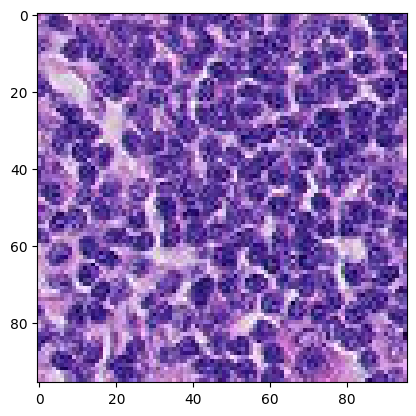

In [31]:
index = 45

# Original Image
plt.imshow(x_test_non[index])

11/11 [==============================] - 1s 57ms/step


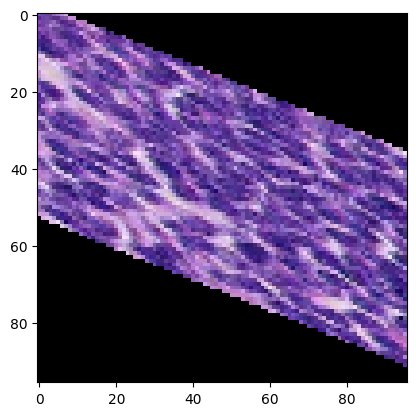

In [33]:
activation_model = m_with_mobilev2.get_layer("model_10")

preds = activation_model.predict(x_test_non)

# Recreated
plt.imshow(preds[index])

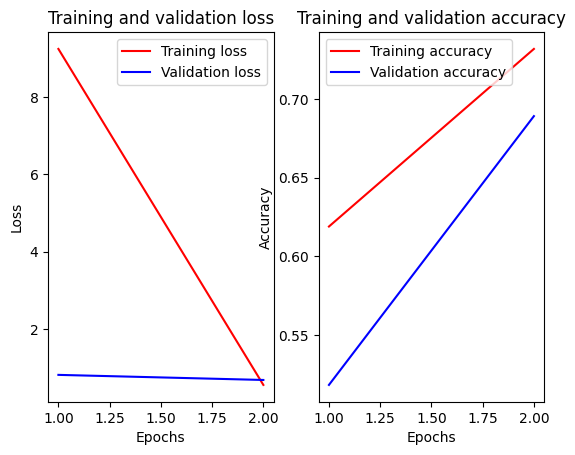

In [34]:
from utils import plot_hist_sideways
plot_hist_sideways(first_hist)

## Without Augmentation

In [35]:


# Layers for feature extraction
mobilev2_ft_extractor = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top= False,
    weights='imagenet'
)
mobilev2_ft_extractor.trainable = False

inputs = tf.keras.layers.Input(shape = (96, 96, 3))
x = create_spatial_transformer((96, 96, 3))(inputs)  
x = mobilev2_ft_extractor(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x)
m_mobilev2 = tf.keras.models.Model(inputs = inputs, outputs = output)

# Compile model
m_mobilev2.compile(
    optimizer = OPTIMIZER,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )





first_hist = m_mobilev2.fit(x = x_val_non, y = y_val_non, validation_data = (x_test_non, y_test_non), epochs = 2)

Building Localization Network with input shape: (None, 96, 96, 3)
Building Bilinear Interpolation Layer with input shape: [TensorShape([None, 96, 96, 3]), TensorShape([None, 2, 3])]
Epoch 1/2
11/11 [==============================] - 16s 1s/step - loss: 9.1865 - accuracy: 0.5854 - val_loss: 0.6774 - val_accuracy: 0.5671
Epoch 2/2
11/11 [==============================] - 10s 941ms/step - loss: 0.5932 - accuracy: 0.5884 - val_loss: 0.7191 - val_accuracy: 0.5854


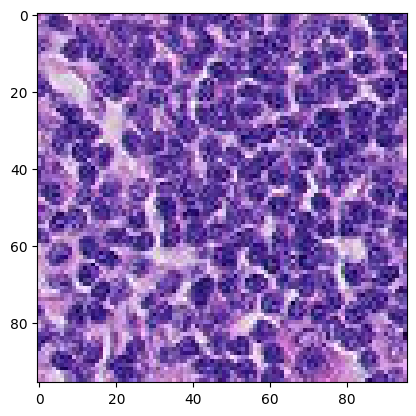

In [36]:

# Original Image
plt.imshow(x_test_non[index])

In [37]:
m_mobilev2.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 model_12 (Functional)       (None, 96, 96, 3)         188086    
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 11520)             0         
                                                                 
 dense_26 (Dense)            (None, 64)                737344    
                                                                 
 dense_27 (Dense)            (None, 2)                 130       
                                                          

11/11 [==============================] - 1s 59ms/step


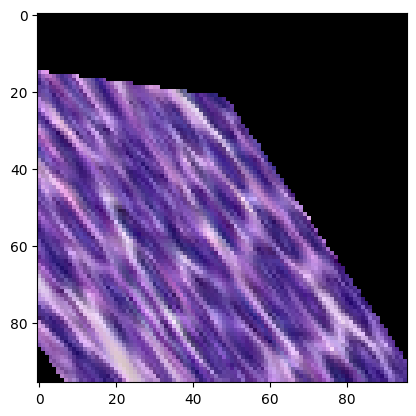

In [39]:
activation_model = m_mobilev2.get_layer("model_12")

preds = activation_model.predict(x_test_non)

# Recreated
plt.imshow(preds[index])

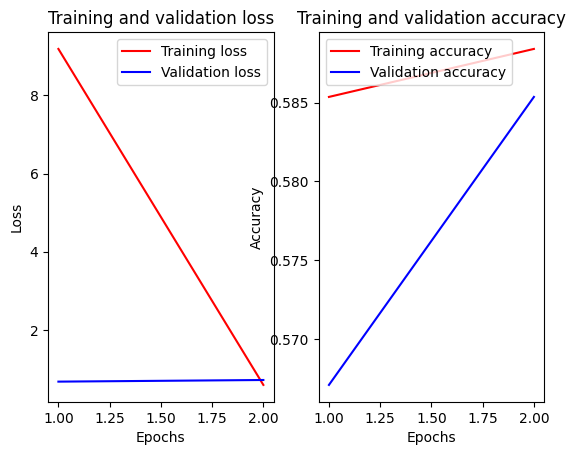

In [40]:
from utils import plot_hist_sideways
plot_hist_sideways(first_hist)